## Decision Tree Learning

- Decision tree classifiers, breaking down data by making decisions based on asking a series of questions
- Based on the features in our training set, model learns a series of questions to infer the class labels of the samples.
- Starting at the root, split the data on the feature that results in the largest **information gain (IG)**. (Objective function)
- **Prune** the tree to avoid overfitting, by setting a limit for the maximal depth of the tree


- Impurity measures (splitting criteria) used in binary decision trees
    - **Gini impurity (I.g)**; Attempts to minimize the probability of misclassification
    - **Entropy (I.h)**; Attempts to maximize the mutual information in the tree
    - **Classification Error (I.e)**

In [11]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

### Impurity Criteria

In [2]:
def gini(p):
    return (p)*(1-(p)) + (1-p)*(1 - (1-p))

def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def error(p):
    return 1 - np.max([p, 1 - p])

### Visual Comparison - Impurity criteria
#### indices for the probability range [0, 1] 


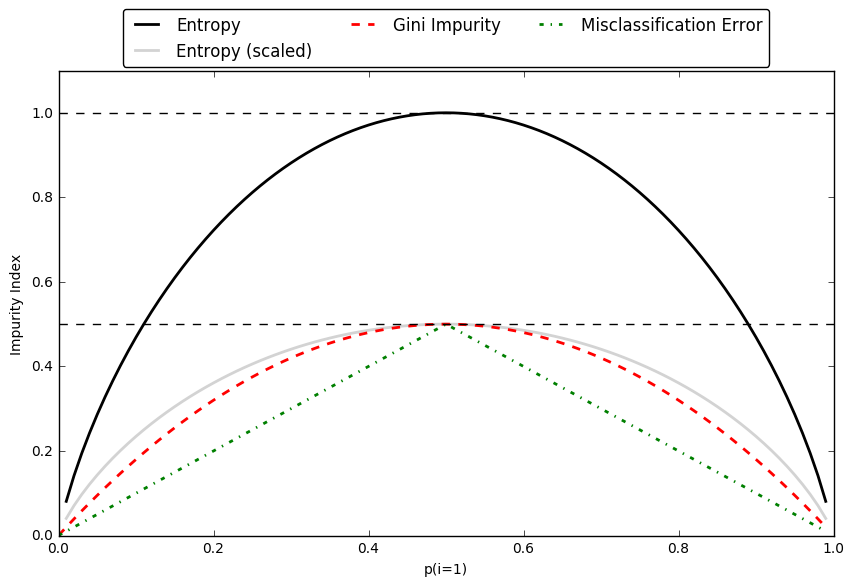

In [12]:
x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p!= 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()

ax = plt.subplot(111)

for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], ['Entropy', 'Entropy (scaled)', 'Gini Impurity', 'Misclassification Error'], 
                         ['-', '-', '--', '-.'],
                         ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')

plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()

### Building a decision tree

In [14]:
# Load the dataset

from sklearn import datasets

iris = datasets.load_iris()

# Assign petal length and petal width to X matrix (150 samples)
X = iris.data[:, [2, 3]]

# Class labels
y = iris.target

# Split the dataset into separate training and test datasets.
from sklearn.cross_validation import train_test_split

# Split the X and y arrays into 30 percent test data, and 70 (45 samples) percent training data (105 samples)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [13]:
# Plotting Function

from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), 
                          np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot all the samples
    for idx, c1 in enumerate(np.unique(y)):
        plt.scatter(x=X[y == c1, 0], y=X[y == c1, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=c1)
        
    # highlight the test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', alpha=1.0, linewidths=1, marker='o', s=55, label='test set')
    

Note; Feature scaling is not a requirement for decision tree algorithms, so we do not used in the data prep.

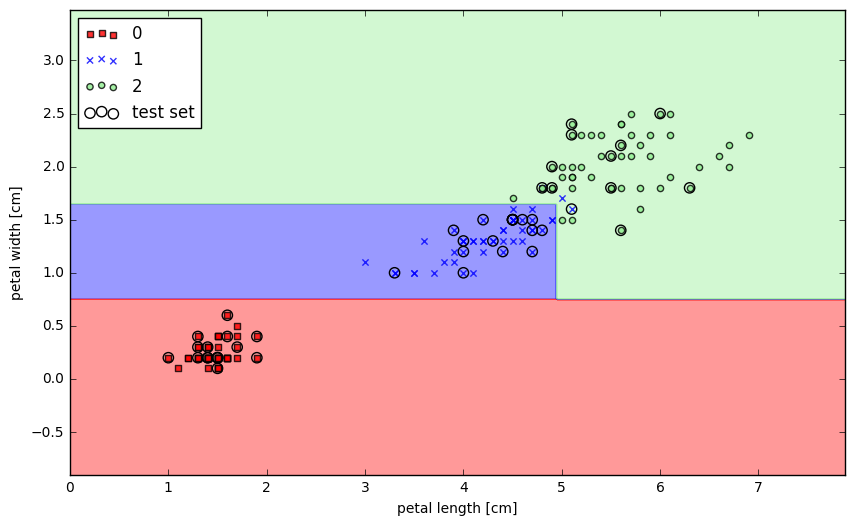

In [16]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

tree.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined, y_combined, classifier=tree, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

### Exporting the decision tree to visualize using GraphViz 

http://www.graphviz.org

In [17]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file='tree.dot', feature_names=['petal length', 'petal width'])

In [18]:
# TODO: Display graphviz PNG Image below.

## Random Forests

- Good classification performance, scalability, and ease of use.
- Considered as an **ensemble** of decision trees
- Combine **weak learners** to build a more robust model, a *stronger learner*, that has a better generalization error and is less susceptible to overfitting.

---

#### Summarized in four steps
1. Draw a random **bootstrap** sample of size **n** (randomly choose n samples from the training set w/ replacement)
2. Grow a decision tree from the bootstrap sample, At each node:
    - Randomly select **d** features without replacement.
    - Split the node using the feature that provides the best split according to the objective function, (maximizing the information gain)
3. Repeat the steps 1 to 2, **k** times.
4. Aggregate the prediction by each tree to assign the class label by **majority vote**. 

---

- Advantages
    - Don't have to worry so much about choosing good hyperparameter values.
    - Typically don't need to prune the random forest, since the ensemble model s quite robust to noise
    - The only parameter we need to care about is the number of trees, **k**, we choose for the random forest.
        - The larger k, the better of performance of the random forest classifier will be (expense of computation)

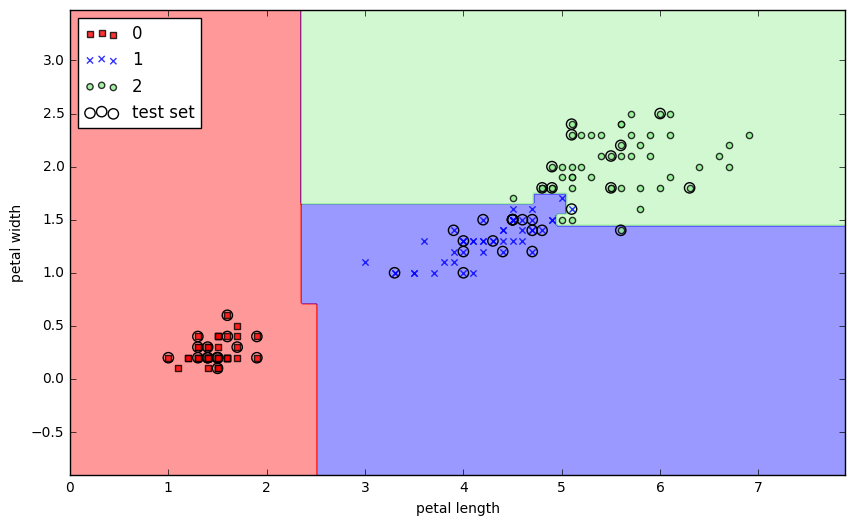

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Train a random forest from 10 decision trees, (n_estimators) and use 2 computational cores (n_jobs)
forest = RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1, n_jobs=2)

# Train the model
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, classifier=forest, test_idx=range(105, 150))
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left')
plt.show()